In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

## Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


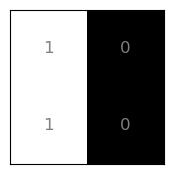

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

### Getting Wavefunction of Dataset

In [4]:
# target_psi = np.zeros(2**4)
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = []
for i in bitstrings_target:
    nums_target += [int(i, 2)]
print(nums_target)

[0, 3, 5, 10, 12, 15]


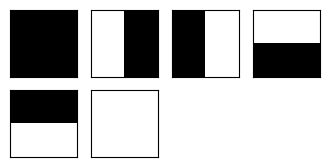

In [5]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [6]:
p1 = np.zeros(2**4)
p2 = np.zeros(2**4)
p3 = np.zeros(2**4)
p4 = np.zeros(2**4)
p5 = np.zeros(2**4)
p6 = np.zeros(2**4)

bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = []
for i in bitstrings_target:
    nums_target += [int(i, 2)]
print(nums_target)

[0, 3, 5, 10, 12, 15]


In [7]:
# target_amps = 1/math.sqrt(len(nums_target))
p1[nums_target[0]] = 1.0
p2[nums_target[1]] = 1.0
p3[nums_target[2]] = 1.0
p4[nums_target[3]] = 1.0
p5[nums_target[4]] = 1.0
p6[nums_target[5]] = 1.0

In [8]:
target_dm = 1/len(nums_target) * (np.outer(p1,p1.conj()) + np.outer(p2,p2.conj()) + np.outer(p3,p3.conj()) + np.outer(p4,p4.conj()) 
                                             + np.outer(p5,p5.conj()) + np.outer(p6,p6.conj()))

In [9]:
np.diag(target_dm)

array([0.16666667, 0.        , 0.        , 0.16666667, 0.        ,
       0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.        , 0.16666667, 0.        , 0.        ,
       0.16666667])

## Functions

In [10]:
from pennylane.math import reduce_statevector
from pennylane import math as qmlmath

n_qubits = 4
n_ancillas = 3
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = qmlmath.conj(qmlmath.transpose(pxy)) # Compute Hermitian conjugate
        return 0.5 * qmlmath.trace(qmlmath.sqrt_matrix(dagger_pxy * pxy))
        # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        pxy_2 = pxy@pxy
        return self.tr_distance(pxy_2)
        # return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        full_psi = self.circ(params)
        px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.trdistance(px,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

In [11]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):
    
    params = qnp.array(input_params, requires_grad=True)
    
    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [12]:
class FidelityLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    # def fidelity(self, px, py):
    #     """
    #     Compute the trace distance of the difference matrix pxy.
        
    #     Parameters:
    #         pxy (numpy.ndarray): Difference of two probability distributions.
        
    #     Returns:
    #         float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
    #     """
    #     # return px.conj().transpose() @ py
    #     return qml.math.fidelity(px,py)
    #     # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        px_dm = qml.math.dm_from_state_vector(px)
        py = py
        return qml.math.fidelity(px_dm,py)
        # return self.tr_distance(pxy)
    
class VQC:

    def __init__(self,circ,fidelity,py):
        self.circ = circ
        self.fidelity = fidelity
        self.py = py

    def vqc_loss(self,params):
        full_psi = self.circ(params)
        # px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.fidelity(full_psi,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

## Training the Model

In [13]:
# key = jax.random.PRNGKey(1)
initial_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * total_qubits), requires_grad=True)

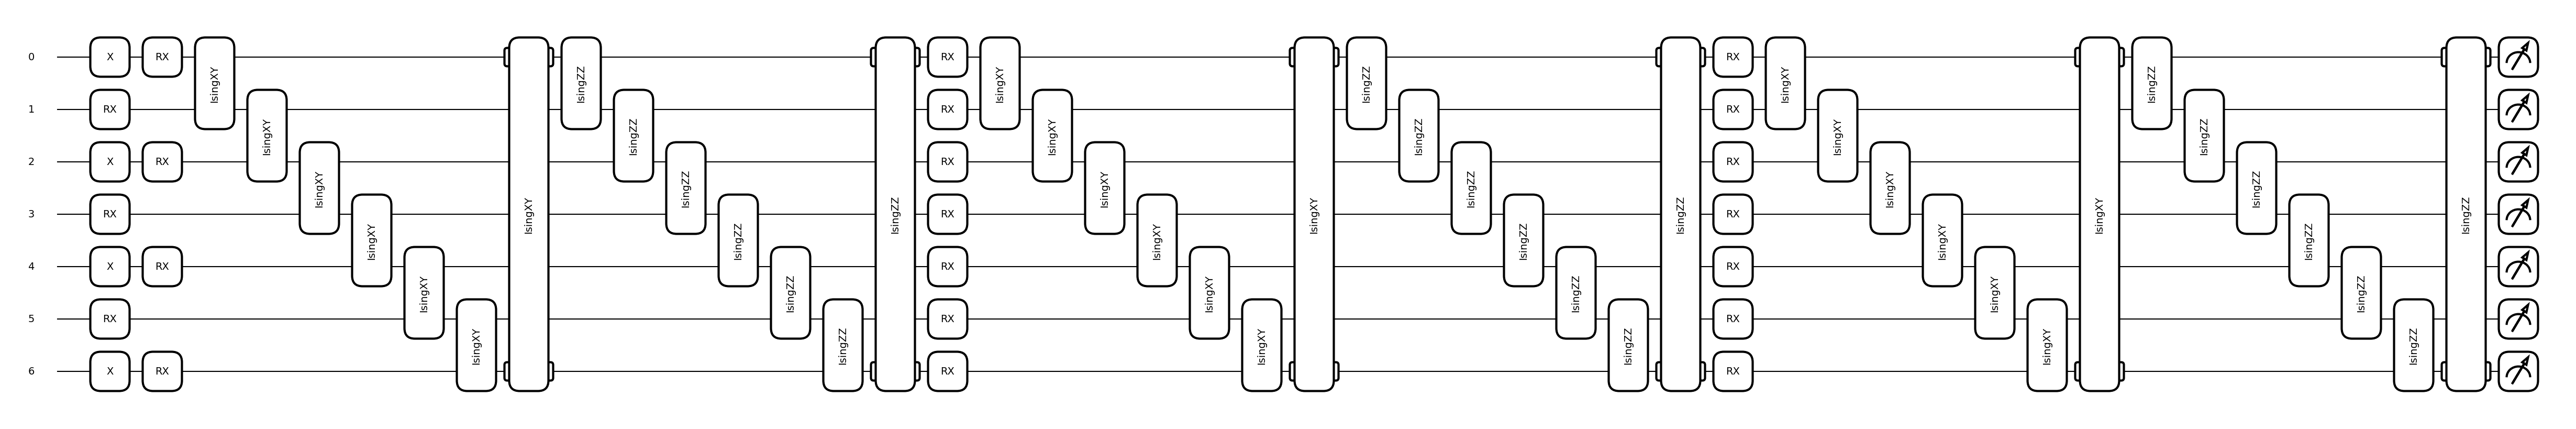

In [14]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [15]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params#.flatten()
# lr = 1
opt = AdamOptimizer(stepsize=0.01)
# opt = GradientDescentOptimizer(stepsize=0.1)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 1500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = qcbm.qcbm_loss(weights)
    weights = opt.step(qcbm.qcbm_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.15473879701796733 Time taken per iter: 0.04751110076904297
Step: 20 Loss: 0.12770512275053608 Time taken per iter: 0.04795479774475098
Step: 30 Loss: 0.11636772977771445 Time taken per iter: 0.020047903060913086
Step: 40 Loss: 0.10866232887225236 Time taken per iter: 0.019152164459228516
Step: 50 Loss: 0.1019721982538328 Time taken per iter: 0.01935100555419922
Step: 60 Loss: 0.0919767464372259 Time taken per iter: 0.020135164260864258
Step: 70 Loss: 0.07975753200422567 Time taken per iter: 0.019259929656982422
Step: 80 Loss: 0.07055891720001152 Time taken per iter: 0.020663976669311523
Step: 90 Loss: 0.06482561395133485 Time taken per iter: 0.018445968627929688
Step: 100 Loss: 0.060814943723486156 Time taken per iter: 0.018963098526000977
Step: 110 Loss: 0.05781577455137252 Time taken per iter: 0.01960611343383789
Step: 120 Loss: 0.05366635498376589 Time taken per iter: 0.019422054290771484
Step: 130 Loss: 0.047537006487349445 Time taken per iter: 0.019299983978271484

Text(0.5, 1.0, 'Loss Over Epochs')

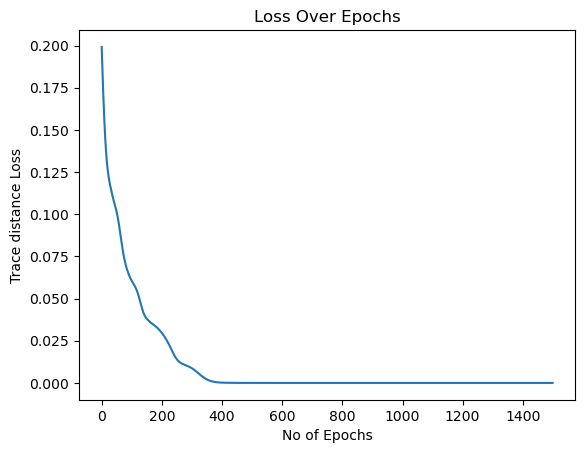

In [16]:
plt.plot(loss)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [17]:
min_loss = loss[np.argmin(loss)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 2.0200875753699723e-08


In [18]:
optimal_params = parameters[np.argmin(loss)]
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

In [19]:
np.round(np.diag(reduced_dm),3)

tensor([0.167+0.j, 0.   -0.j, 0.   +0.j, 0.167-0.j, 0.   -0.j, 0.167-0.j,
        0.   +0.j, 0.   +0.j, 0.   -0.j, 0.   +0.j, 0.167+0.j, 0.   -0.j,
        0.167+0.j, 0.   -0.j, 0.   -0.j, 0.167-0.j], requires_grad=True)

## Training over the Register Basis

In [20]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        # qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])
    # qml.IsingXY(ising_params1[-1],wires=[n_qubits+total_qubits-1,n_qubits])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingZZ(ising_params2[-1],wires=[n_qubits+total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)


    params = qnp.array(input_params, requires_grad=True)

    for i in range(folds):
        vqc_circuit(params=params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [21]:
reg_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * n_ancillas), requires_grad=True)

(<Figure size 7600x800 with 1 Axes>, <Axes: >)

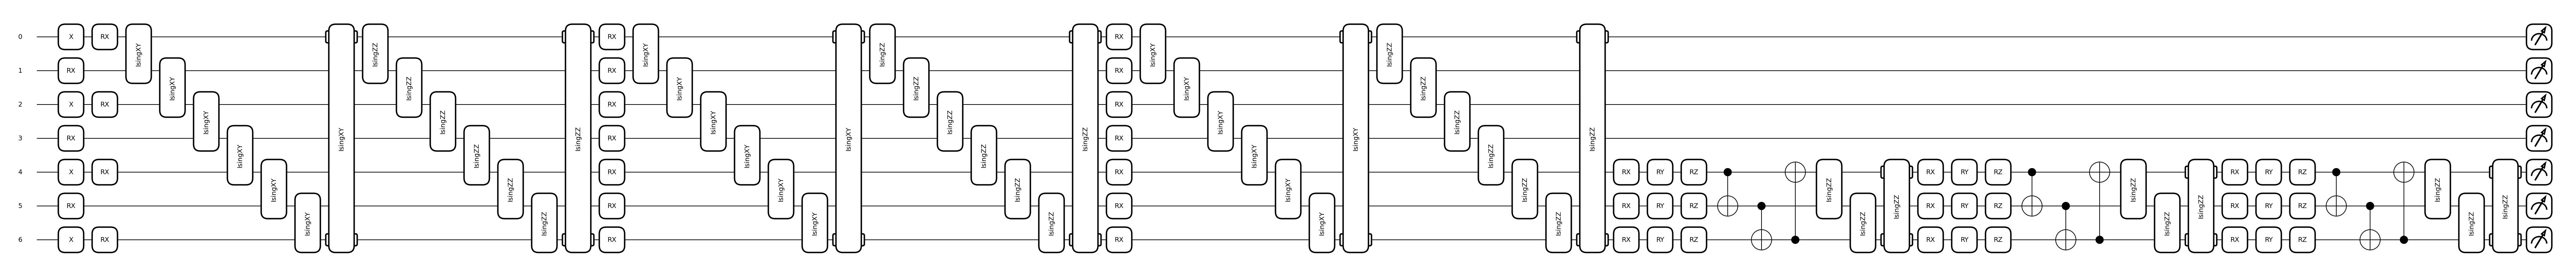

In [22]:
qml.draw_mpl(reg_circuit)(reg_params)

In [23]:
f1 = np.zeros(2**7)
f2 = np.zeros(2**7)
f3 = np.zeros(2**7)
f4 = np.zeros(2**7)
f5 = np.zeros(2**7)
f6 = np.zeros(2**7)

bitstrings_full_target = ['0000000','0011001','0101010','1010011','1100100','1111101']
nums_full_target = []
for i in bitstrings_full_target:
    nums_full_target += [int(i, 2)]
print(nums_full_target)

[0, 25, 42, 83, 100, 125]


In [24]:
# target_amps = 1/math.sqrt(len(nums_target))
f1[nums_full_target[0]] = 1.0
f2[nums_full_target[1]] = 1.0
f3[nums_full_target[2]] = 1.0
f4[nums_full_target[3]] = 1.0
f5[nums_full_target[4]] = 1.0
f6[nums_full_target[5]] = 1.0

target_full_dm = 1/len(nums_full_target) * (np.outer(f1,f1.conj()) + np.outer(f2,f2.conj()) + np.outer(f3,f3.conj()) + np.outer(f4,f4.conj()) 
                                             + np.outer(f5,f5.conj()) + np.outer(f6,f6.conj()))

In [25]:
np.diag(target_full_dm)

array([0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [26]:
fid = FidelityLoss()
vqc = VQC(reg_circuit,fid,target_full_dm)

weights = reg_params
opt = AdamOptimizer(stepsize=0.1)

reg_loss = []
reg_parameters = []
n_epochs = 500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = vqc.vqc_loss(weights)
    weights = opt.step(vqc.vqc_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    reg_loss.append(loss_val)
    reg_parameters.append(weights)


Step: 10 Loss: 0.0012728787334443106 Time taken per iter: 0.053238868713378906
Step: 20 Loss: 0.0004129083840324396 Time taken per iter: 0.05396413803100586
Step: 30 Loss: 6.611641393206198e-05 Time taken per iter: 0.05342698097229004
Step: 40 Loss: 1.1468456893675572e-05 Time taken per iter: 0.07144021987915039
Step: 50 Loss: 9.484014286498152e-06 Time taken per iter: 0.05669403076171875
Step: 60 Loss: 4.718250218980574e-06 Time taken per iter: 0.09057807922363281
Step: 70 Loss: 1.4605622346270552e-06 Time taken per iter: 0.05190777778625488
Step: 80 Loss: 3.938624213865362e-07 Time taken per iter: 0.05456805229187012
Step: 90 Loss: 1.519415622581323e-07 Time taken per iter: 0.05343317985534668
Step: 100 Loss: 3.935306035899878e-08 Time taken per iter: 0.05332779884338379
Step: 110 Loss: 1.5982781107179355e-08 Time taken per iter: 0.07130193710327148
Step: 120 Loss: 5.237633418691797e-09 Time taken per iter: 0.06897306442260742
Step: 130 Loss: 2.664633492740898e-09 Time taken per iter

In [27]:
optimal_reg_params = reg_parameters[np.argmin(reg_loss)]
full_psi = reg_circuit(optimal_reg_params)

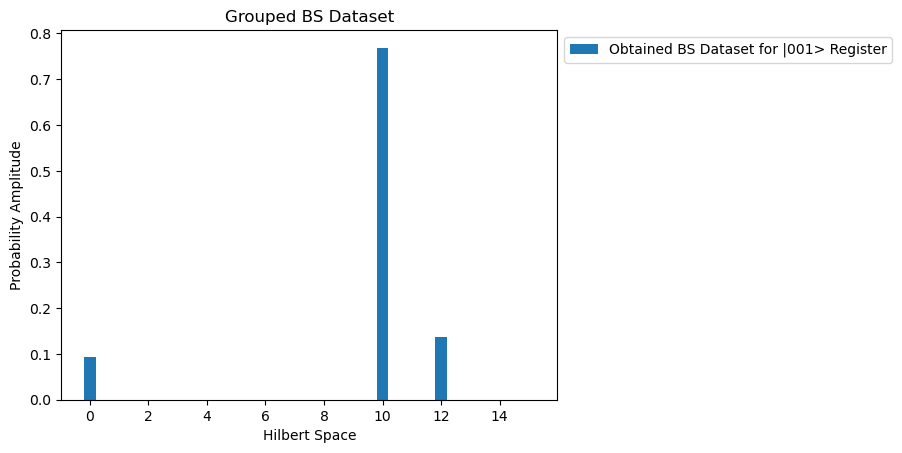

In [43]:
image = qnp.round(psi[4::8],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [29]:
nums_full_target

[0, 25, 42, 83, 100, 125]